# KDD Cup 1998: Direct Marketing for Profit Optimization

**Objective** 

To understand how to best target people who are most likely to give to charity. 

The tasks are a classification problem where goal is to predict which people are more likely to donate to a charity and a regression problem where the goal is to estimate the return from a direct mailing in order to maximize donation profits.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import arange
from pandas_profiling import ProfileReport
from category_encoders import TargetEncoder
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.metrics import mean_absolute_error, precision_recall_curve, roc_auc_score, r2_score
import time
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold, validation_curve
import datetime
from datetime import datetime 
import lightgbm as lgb
from sklearn.linear_model import RidgeCV, Ridge
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import norm, skew #for some statistics

In [3]:
# Reading training data
train_data = pd.read_csv('http://kdd.org/cupfiles/KDDCupData/1998/cup98lrn.zip')
# Reading validation data
validation_data = pd.read_csv('http://kdd.org/cupfiles/KDDCupData/1998/cup98val.zip')
# Reading validation data result
validation_result = pd.read_csv('http://kdd.org/cupfiles/KDDCupData/1998/valtargt.txt')

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95412 entries, 0 to 95411
Columns: 481 entries, ODATEDW to GEOCODE2
dtypes: float64(97), int64(310), object(74)
memory usage: 350.1+ MB


In [5]:
validation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96367 entries, 0 to 96366
Columns: 479 entries, ODATEDW to GEOCODE2
dtypes: float64(96), int64(309), object(74)
memory usage: 352.2+ MB


In [6]:
validation_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96367 entries, 0 to 96366
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CONTROLN  96367 non-null  int64  
 1   TARGET_B  96367 non-null  int64  
 2   TARGET_D  96367 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.2 MB


In [7]:
#Check for duplicates
print(train_data.duplicated().any())
print(train_data['CONTROLN'].duplicated().any())

False
False


No duplicates are found in the data

In [8]:
Y_train_data = train_data[['CONTROLN', 'TARGET_B', 'TARGET_D']]
Y_validation_data = validation_data[['CONTROLN']]

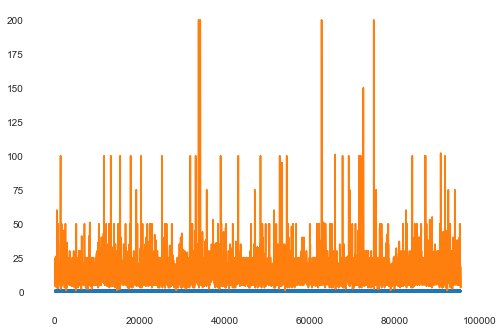

In [9]:
# Distribution of the target variables
plt.plot(train_data.TARGET_B)
plt.plot(train_data[train_data.TARGET_D > 0].TARGET_D)

In [10]:
Y_validation_data = Y_validation_data.set_index('CONTROLN').join(validation_result.set_index('CONTROLN'))
Y_validation_data[Y_validation_data.TARGET_B.isnull()]
Y_validation_data.TARGET_B = Y_validation_data.TARGET_B.astype(int)

### Data Understanding

In [11]:
profile = ProfileReport(train_data, title='Pandas Profiling Report', minimal=True)

In [12]:
#profile.to_file("data_report.html")

### Data Cleaning & Feature Engineering

In [13]:
mode_firstdate_train = int(train_data['FISTDATE'].mode().values)
train_data['FISTDATE'].replace(0,mode_firstdate_train, inplace=True)
mode_firstdate_validation = int(validation_data['FISTDATE'].mode().values)
validation_data['FISTDATE'].replace(0,mode_firstdate_validation, inplace=True)

In [14]:
def Reformatting_columns(df):
    df[['RECINHSE', 'RECP3','RECPGVG','RECSWEEP','MAJOR','PEPSTRFL','LIFESRC']].replace(r'\s+',0,regex=True, inplace=True)
    df[['NOEXCH','RECINHSE', 'RECP3','RECPGVG','RECSWEEP','MAJOR','PEPSTRFL']].replace('X',1,regex=True, inplace=True)
    df[['MAILCODE','SOLP3','SOLIH']].replace(r'\s+',1,regex=True, inplace=True)
    df['MAILCODE'].replace('B',0,inplace=True)
    df['ZIP'] = df['ZIP'].apply(lambda x: x.rstrip('-')) 
    df['GENDER'].replace('M',1,inplace=True)
    df['GENDER'].replace('F',0,inplace=True)
    df['GENDER'].replace(r'[AUJC\s]+',np.nan,regex=True,inplace=True)
    df['LASTDATE_date'] = df['LASTDATE'].apply(lambda x:'-'.join([str(x)[:2],str(x)[2:]]))
    df['LASTDATE_date'] = pd.to_datetime(df['LASTDATE_date'], format='%y-%m')
    df['FISTDATE_date'] = df['FISTDATE'].apply(lambda x:'-'.join([str(x)[:2],str(x)[2:]]))
    df['FISTDATE_date'] = pd.to_datetime(df['FISTDATE_date'], format='%y-%m')
    df['nb_months'] = ((df.LASTDATE_date - df.FISTDATE_date)/np.timedelta64(1, 'M'))
    df['Children'] = np.where(((df.CHILD03 == ' ') & (df.CHILD07 == ' ') & (df.CHILD12 == ' ') & (df.CHILD18 == ' ')), 0, 1)
    return df

In [15]:
train_data = Reformatting_columns(train_data)
validation_data = Reformatting_columns(validation_data)

In [16]:
train_data.loc[(train_data.nb_months < 0) ] = 0
validation_data.loc[(validation_data.nb_months < 0) ] = 0

In [17]:
#Group uncommon titles (<0.1% of occurences)
#211  = Other
s = train_data['TCODE'].value_counts()
for item in s.keys():
    if s[item] < 0.001*train_data.shape[0]:
        train_data['TCODE'].replace(item,'211',inplace=True)
train_data['TCODE'] = train_data['TCODE'].astype(int)

#Replace missing GENDER values if TCODE gives gender
for row in train_data.index[train_data['GENDER'].isnull()].tolist():
    a = train_data.loc[row,'TCODE']
    if a == 0 or a == 1:
        train_data.loc[row,'GENDER'] = 1
    elif a == 2 or a == 3 or a == 28:
        train_data.loc[row,'GENDER'] = 0
    
#Drop irrelevant, duplicated or underfilled records
print('Dropping sparse or unneccesary columns...')

l1 = ['RDATE_'+str(n) for n in range(3,25)]
l2 = ['ADATE_'+str(n) for n in range(2,25)]

l1.extend(l2)

Drop_list = list(set(l1)) #To remove duplicates, convert to a set
train_data.drop(Drop_list,axis = 1,inplace = True)
print('Number of dropped Columns = ' , len(Drop_list))

Dropping sparse or unneccesary columns...
Number of dropped Columns =  45


In [18]:
#Group uncommon titles (<0.1% of occurences)
#211  = Other
s = validation_data['TCODE'].value_counts()
for item in s.keys():
    if s[item] < 0.001*validation_data.shape[0]:
        validation_data['TCODE'].replace(item,'211',inplace=True)
validation_data['TCODE'] = validation_data['TCODE'].astype(int)

#Replace missing GENDER values if TCODE gives gender
for row in validation_data.index[validation_data['GENDER'].isnull()].tolist():
    a = validation_data.loc[row,'TCODE']
    if a == 0 or a == 1:
        validation_data.loc[row,'GENDER'] = 1
    elif a == 2 or a == 3 or a == 28:
        validation_data.loc[row,'GENDER'] = 0
    
#Drop irrelevant, duplicated or underfilled records
print('Dropping sparse or unneccesary columns...')

validation_data.drop(Drop_list,axis = 1,inplace = True)
print('Number of dropped Columns = ' , len(Drop_list))

Dropping sparse or unneccesary columns...
Number of dropped Columns =  45


### Bi-variate Analysis

Text(0.5, 1.0, 'Distribution by donators status')

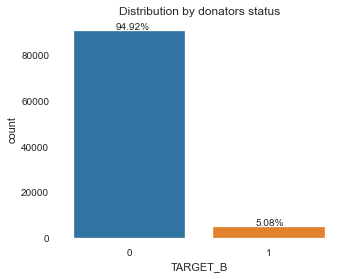

In [19]:
plt.figure(figsize=(5,4))
g1=sns.countplot(x='TARGET_B',data = train_data)
for p in g1.patches:
     g1.annotate('{:.2f}%'.format((p.get_height() / train_data.shape[0]) * 100, 2), (p.get_x() + 0.30, p.get_height()+500))
plt.title('Distribution by donators status')

Text(0.5, 1.0, 'Significance of Income on Donation')

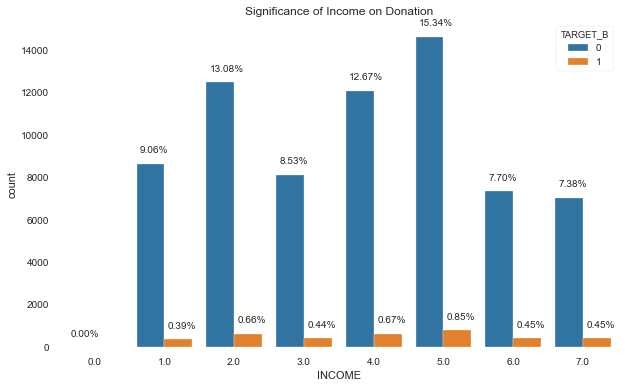

In [20]:
g1=sns.countplot(x=train_data['INCOME'],hue = train_data['TARGET_B'])
fig = plt.gcf()
fig.set_size_inches(10,6)
for p in g1.patches:
     g1.annotate('{:.2f}%'.format((p.get_height() / train_data.shape[0]) * 100, 2), 
                   (p.get_x() + 0.05, p.get_height()+500))
plt.title('Significance of Income on Donation')

Text(0.5, 1.0, 'Significance of Wealth on Donation')

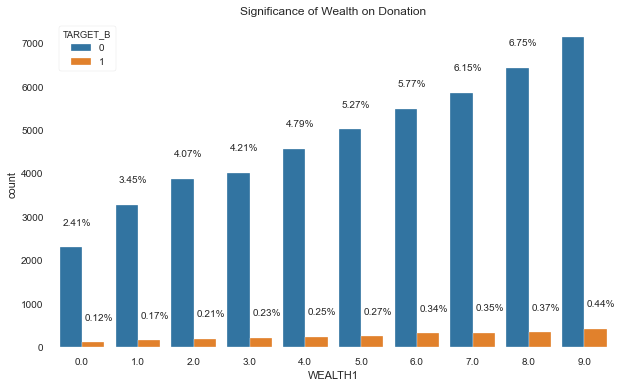

In [21]:
g1=sns.countplot(x=train_data['WEALTH1'],hue = train_data['TARGET_B'])
fig = plt.gcf()
fig.set_size_inches(10,6)
for p in g1.patches:
     g1.annotate('{:.2f}%'.format((p.get_height() / train_data.shape[0]) * 100, 2), 
                   (p.get_x() + 0.05, p.get_height()+500))
plt.title('Significance of Wealth on Donation')

Text(0.5, 1.0, 'Significance of Children on Donation')

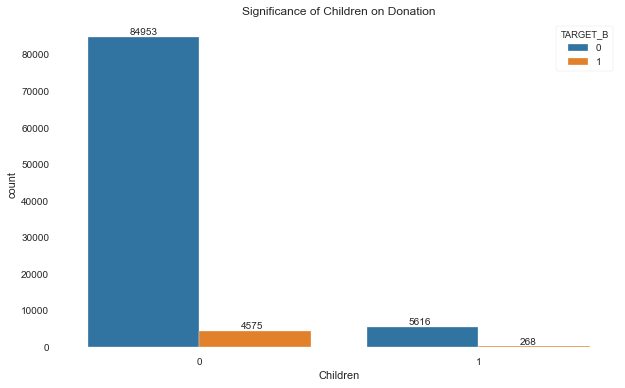

In [22]:
g1=sns.countplot(x=train_data['Children'],hue = train_data['TARGET_B'])
fig = plt.gcf()
fig.set_size_inches(10,6)
for p in g1.patches:
     g1.annotate(p.get_height(), 
                   (p.get_x() + 0.15, p.get_height()+500))
plt.title('Significance of Children on Donation')

Text(0.5, 1.0, 'Significance of Gender on Donation')

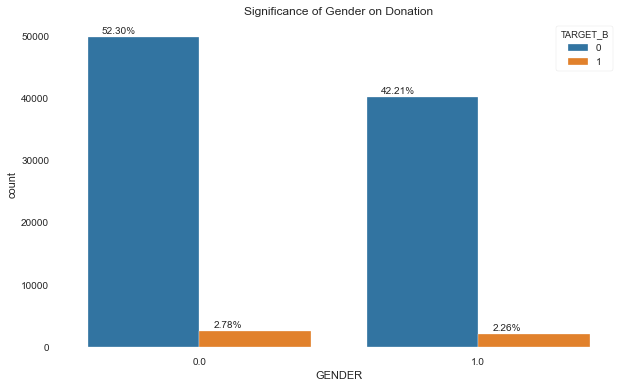

In [23]:
g1=sns.countplot(x=train_data['GENDER'],hue = train_data['TARGET_B'])
fig = plt.gcf()
fig.set_size_inches(10,6)
for p in g1.patches:
     g1.annotate('{:.2f}%'.format((p.get_height() / train_data.shape[0]) * 100, 2), 
                   (p.get_x() + 0.05, p.get_height()+500))
plt.title('Significance of Gender on Donation')

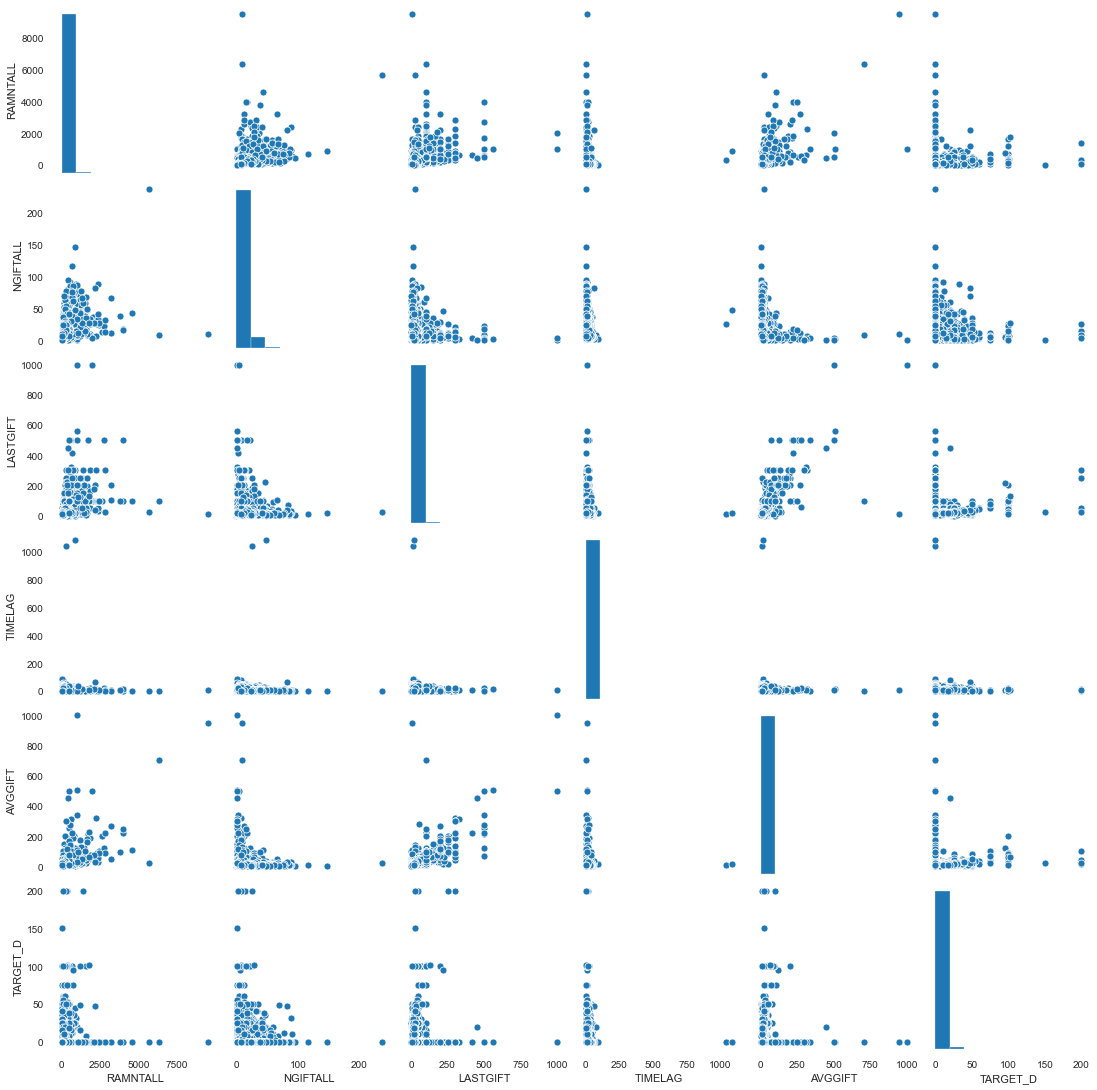

In [24]:
sns.pairplot(train_data[["RAMNTALL", "NGIFTALL","LASTGIFT","TIMELAG", "AVGGIFT", "TARGET_D"]])

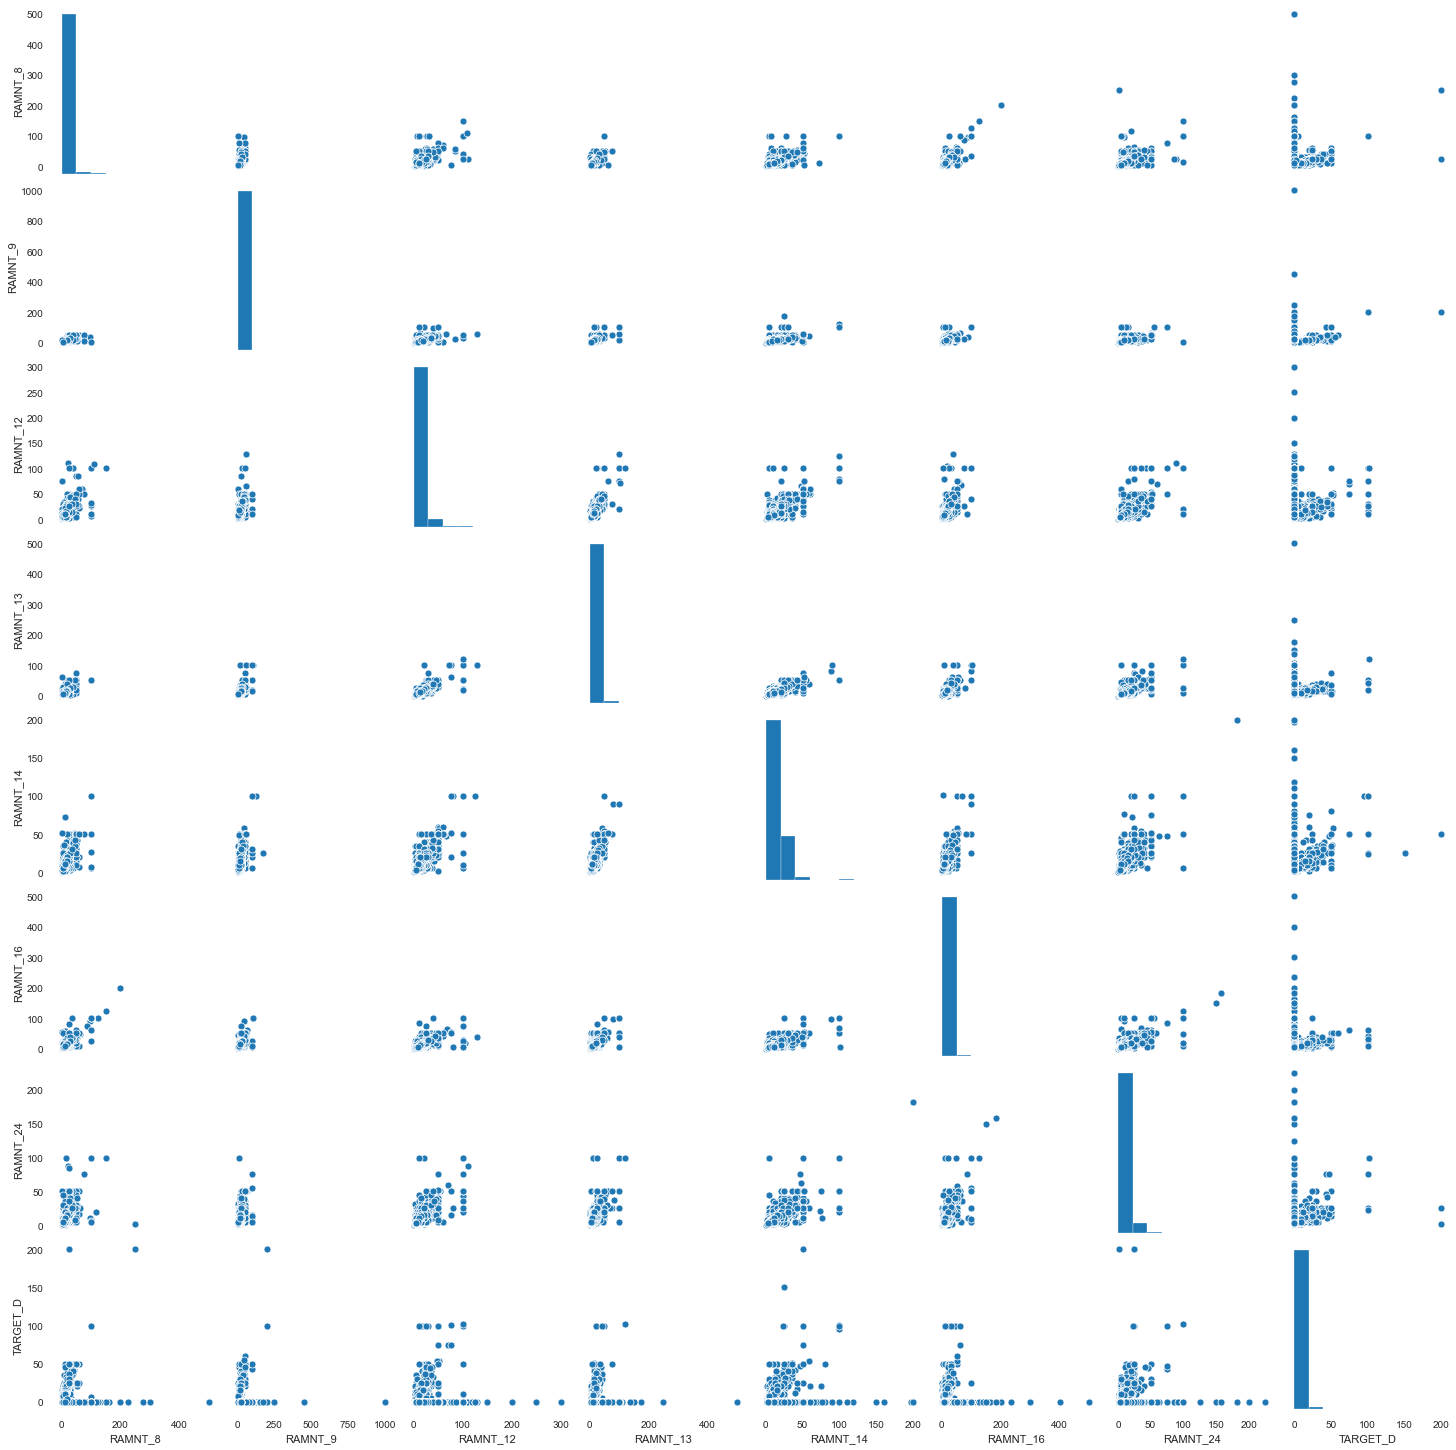

In [25]:
sns.pairplot(train_data[['RAMNT_8', 'RAMNT_9', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_16', 'RAMNT_24', "TARGET_D"]])

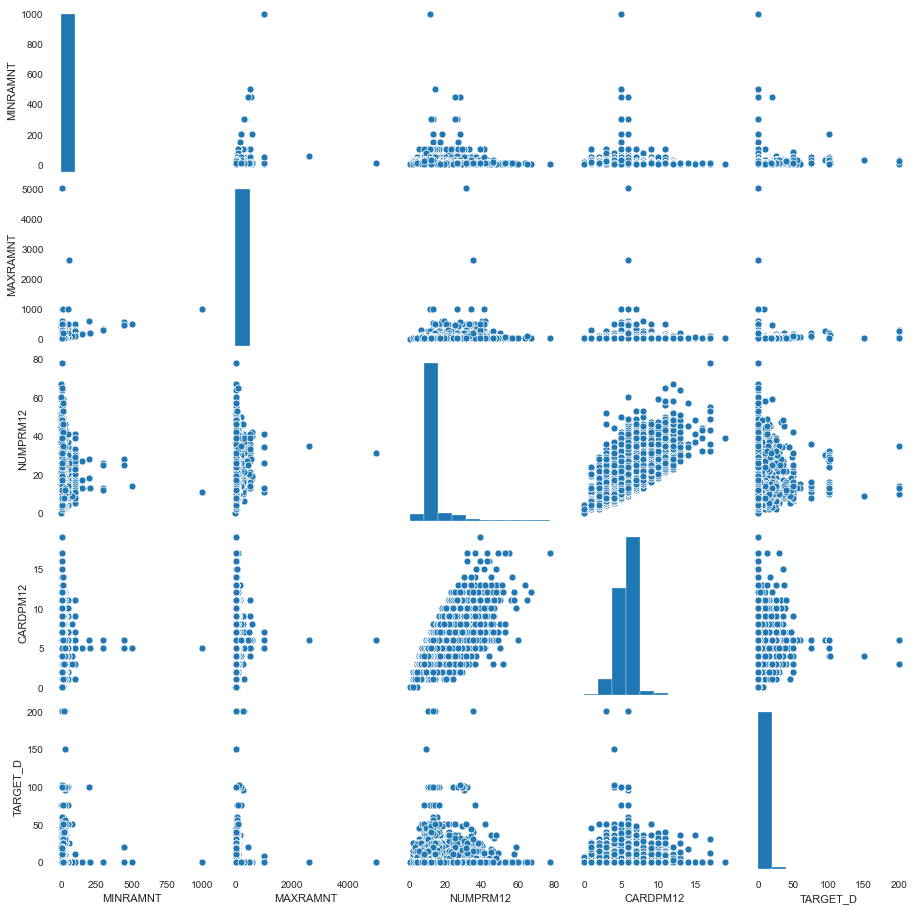

In [26]:
sns.pairplot(train_data[['MINRAMNT', 'MAXRAMNT', 'NUMPRM12', 'CARDPM12', "TARGET_D"]])

**RAMNTALL, MINRAMNT, MAXRAMNT, LASTGIFT, TIMELAG, AVGGIFT --> positive correlations with donation amount**

**RAMNT_8, RAMNT_9, RAMNT_12, RAMNT_13, RAMNT_14, RAMNT_16, RAMNT_24 --> Dollar amount has positive correlation with donation amount**

**NGIFTALL, NUMPRM12, CARDPM12 --> negative correlations with donation amount**

[Text(0, 0.5, 'Number of months between First gift and recent gift')]

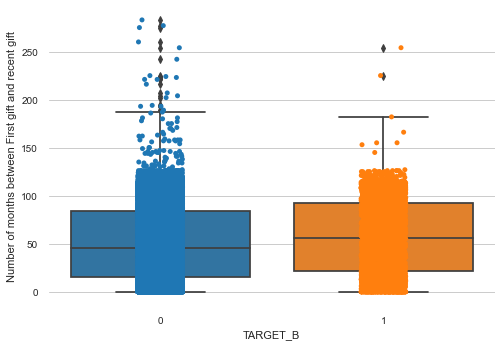

In [27]:
sns.set_style('whitegrid')
ax= sns.boxplot(x='TARGET_B',y='nb_months',data=train_data)
ax= sns.stripplot(x='TARGET_B',y='nb_months', data=train_data)
ax.set(ylabel ='Number of months between First gift and recent gift')

In [28]:
train_data.drop(columns=['CONTROLN', 'TARGET_B', 'TARGET_D'], axis=1, inplace=True)
validation_data.drop(columns=['CONTROLN'], axis=1, inplace=True)

In [29]:
train_df = train_data.copy()

#### Drop columns with 99.5% null values

In [30]:
def find_null_values(threshold_of_null=0):
    
    null_columns = np.where(train_df.isna().sum() > threshold_of_null)[0]
    prop = (len(null_columns) / train_df.shape[1])*100    

    print(f'{round(prop,2)}% ({len(null_columns)}) of columns in the dataset have at least {threshold_of_null} null values.')
    
find_null_values(train_df.shape[0]*0.995)

0.69% (3) of columns in the dataset have at least 94934.94 null values.


In [31]:
indices = np.where(train_df.isna().sum() > train_df.shape[0]*0.995)[0]
null_columns = train_df.columns[indices].values.tolist()

# Drops cols with 99.5% null values
train_df = train_df.drop(null_columns, axis = 1)
validation_data = validation_data.drop(null_columns, axis = 1)

In [32]:
def get_redundant_vars(dat):
    '''
    This method outputs a set of redundant variables.
    '''
    redundant_vars = []
    # Identifies numerical variables with variance zero < 0.1%
    #sel = feature_selection.VarianceThreshold(threshold = 0.001)
    dat_var = dat.var()
    redundant_vars.extend(dat_var.index[dat_var < 0.001])

    # Identifies variables that are too sparse (less than 1%)
    idxs = dat.count() < int(dat.shape[0] * .01)
    redundant_vars.extend(dat.columns[idxs])

    return redundant_vars
# Gets some redundant variables based on variance, sparsity
redundant_vars = get_redundant_vars(train_df)

In [33]:
# Drops cols with redundent values
train_df = train_df.drop(redundant_vars, axis = 1)
validation_data = validation_data.drop(redundant_vars, axis = 1)

In [34]:
numerical = [var for var in train_df.columns if train_df[var].dtype!='O']

print('There are {} numerical variables\n'.format(len(numerical)))
categorical = [var for var in train_df.columns if train_df[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

There are 358 numerical variables

There are 75 categorical variables



### Missing value Treatment

In [35]:
encoder = TargetEncoder()
train_df_target_encoded = encoder.fit_transform(train_df[categorical], Y_train_data['TARGET_B'])
train_df = pd.concat([train_df[numerical], train_df_target_encoded], axis=1)

validation_data_target_encoded = encoder.transform(validation_data[categorical])
validation_data = pd.concat([validation_data[numerical], validation_data_target_encoded], axis=1)

In [36]:
# make copy to avoid changing original data (when Imputing)
new_data = train_df.copy()
validation_data_copy = validation_data.copy()

# make new columns indicating what will be imputed
cols_with_missing = (col for col in new_data.columns 
                                 if new_data[col].isnull().any())

cols_with_missing_validation = (col for col in validation_data.columns 
                                 if validation_data[col].isnull().any())

for col in cols_with_missing:
    new_data[col + '_was_missing'] = new_data[col].isnull()
    
for col in cols_with_missing_validation:
    validation_data[col + '_was_missing'] = validation_data[col].isnull()

# Imputation
my_imputer = SimpleImputer()
new_data_imputed = pd.DataFrame(my_imputer.fit_transform(new_data))
validation_data_imputed = pd.DataFrame(my_imputer.transform(validation_data))
new_data_imputed.columns = new_data.columns
validation_data_imputed.columns = validation_data.columns

In [37]:
#Important features from manual inspection
Main_columns = ["ODATEDW", "OSOURCE",  "ZIP", "RECINHSE", "MDMAUD", "DOMAIN", "CLUSTER", "AGE", "HOMEOWNR",
"Children", "NUMCHLD","INCOME", "GENDER", "WEALTH1", 
"COLLECT1", "VETERANS", "BIBLE", "CATLG", "PETS",
"PHOTO", "CRAFTS", "GARDENIN", "BOATS", "WALKER", "LIFESRC", "PEPSTRFL",
"CARDPM12", "NUMPRM12","RAMNTALL", "NGIFTALL",  "MINRAMNT", "MAXRAMNT",
"LASTGIFT", "LASTDATE", "TIMELAG", "AVGGIFT", "RFA_2F", "RFA_2A", "CLUSTER2", "GEOCODE2"]

### Collienearity Treatment

**Correlation Matrices**
Correlation matrices are the essence of understanding our data. We want to know if there are features that influence heavily in predicting whether a specific email results in donation. 

In [38]:
corr_matrix = new_data_imputed.corr()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.9 and less than -0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
to_drop1 = [column for column in upper.columns if any(upper[column] < -0.9)]

to_drop.extend(to_drop1)

new_data_imputed.drop(columns=to_drop, axis=1, inplace=True)
validation_data_imputed.drop(columns=to_drop, axis=1, inplace=True)

**Summary and Explanation:**

Negative Correlations: 86 features are negatively correlated with each other. 

Positive Correlations: 6 features are positively correlated with each other.

### Feature Selection

In [39]:
# Normalize feature vector
X = StandardScaler().fit_transform(new_data_imputed)

In [40]:
# Encode categorical variables
y = Y_train_data['TARGET_B']

In [41]:
import boruta
from boruta import BorutaPy

# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=100)

# find all relevant features
feat_selector.fit(X, y)

# check selected features
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	390
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	390
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	390
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	390
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	390
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	390
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	390
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	65
Tentative: 	51
Rejected: 	274
Iteration: 	9 / 100
Confirmed: 	65
Tentative: 	51
Rejected: 	274
Iteration: 	10 / 100
Confirmed: 	65
Tentative: 	51
Rejected: 	274
Iteration: 	11 / 100
Confirmed: 	65
Tentative: 	51
Rejected: 	274
Iteration: 	12 / 100
Confirmed: 	65
Tentative: 	36
Rejected: 	289
Iteration: 	13 / 100
Confirmed: 	65
Tentative: 	36
Rejected: 	289
Iteration: 	14 / 100
Confirmed: 	65
Tentative: 	36
Rejected: 	289
Iteration: 	15 / 100
Confirmed: 	65
Tentative: 	36
Rejected: 	289
Iteration: 	16 / 100
Confirmed: 	

In [42]:
accepted_columns = feat_selector.support_.tolist()

train_filtered = new_data_imputed.loc[:,accepted_columns]
validation_filtered = validation_data_imputed.loc[:,accepted_columns]

In [43]:
new_data_imputed.loc[:,accepted_columns].columns

Index(['ODATEDW', 'AGE', 'HHN2', 'HV1', 'HVP3', 'HVP5', 'RP3', 'DMA', 'IC1',
       'IC5', 'IC11', 'HHAS3', 'EC2', 'EC7', 'POBC2', 'CARDPM12', 'NUMPRM12',
       'RAMNT_8', 'RAMNT_9', 'RAMNT_12', 'RAMNT_13', 'RAMNT_14', 'RAMNT_16',
       'RAMNT_18', 'RAMNT_24', 'RAMNTALL', 'NGIFTALL', 'MINRAMNT', 'MINRDATE',
       'MAXRAMNT', 'MAXRDATE', 'LASTGIFT', 'LASTDATE', 'NEXTDATE', 'AVGGIFT',
       'RFA_2F', 'OSOURCE', 'STATE', 'ZIP', 'DOMAIN', 'CLUSTER', 'PEPSTRFL',
       'RFA_2', 'RFA_5', 'RFA_6', 'RFA_7', 'RFA_9', 'RFA_10', 'RFA_11',
       'RFA_13', 'RFA_14', 'RFA_15', 'RFA_16', 'RFA_17', 'RFA_18', 'RFA_19',
       'RFA_20', 'RFA_21', 'RFA_22', 'RFA_23', 'RFA_24', 'RFA_2A',
       'LASTDATE_date', 'FISTDATE_date', 'RAMNT_8_was_missing',
       'RAMNT_14_was_missing'],
      dtype='object')

In [44]:
train_filtered['RAMNT_8']

0        15.672972
1        15.672972
2        15.672972
3        15.672972
4        15.000000
           ...    
95407    15.672972
95408    15.672972
95409    10.000000
95410    15.672972
95411    15.672972
Name: RAMNT_8, Length: 95412, dtype: float64

In [45]:
train_filtered[train_filtered['RAMNT_8'] > 5]

,ODATEDW,AGE,HHN2,HV1,HVP3,HVP5,RP3,DMA,IC1,IC5,...,RFA_20,RFA_21,RFA_22,RFA_23,RFA_24,RFA_2A,LASTDATE_date,FISTDATE_date,RAMNT_8_was_missing,RAMNT_14_was_missing
0,8901.0,60.000000,33.0,479.0,13.0,47.0,17.0,682.0,307.0,12883.0,...,0.068085,0.065428,0.059733,0.056130,0.050030,0.064698,0.048552,0.046043,1.0,0.0
1,9401.0,46.000000,21.0,5468.0,98.0,99.0,91.0,803.0,1088.0,36175.0,...,0.026622,0.028302,0.028409,0.047358,0.040286,0.035624,0.048552,0.044218,1.0,1.0
2,9001.0,61.610423,35.0,497.0,6.0,50.0,9.0,518.0,251.0,11576.0,...,0.050638,0.050581,0.074976,0.072693,0.073298,0.064698,0.048552,0.052181,1.0,0.0
3,8701.0,70.000000,27.0,1000.0,50.0,92.0,17.0,862.0,386.0,15130.0,...,0.057186,0.058220,0.061512,0.047358,0.045656,0.064698,0.048552,0.051037,1.0,0.0
4,8601.0,78.000000,26.0,576.0,2.0,67.0,74.0,528.0,240.0,9836.0,...,0.066975,0.074074,0.028169,0.076401,0.085843,0.043779,0.058568,0.050759,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,9601.0,61.610423,32.0,988.0,49.0,92.0,92.0,743.0,433.0,18807.0,...,0.050638,0.050581,0.044760,0.047358,0.045656,0.035624,0.056395,0.025427,1.0,1.0
95408,9601.0,48.000000,20.0,1679.0,88.0,97.0,44.0,618.0,806.0,26538.0,...,0.050638,0.050581,0.044760,0.047358,0.045656,0.043779,0.056672,0.033520,1.0,1.0
95409,9501.0,60.000000,29.0,376.0,0.0,9.0,78.0,551.0,263.0,12178.0,...,0.050638,0.056038,0.054125,0.047358,0.045656,0.064698,0.070732,0.045696,0.0,1.0
95410,8601.0,58.000000,26.0,2421.0,99.0,99.0,90.0,803.0,552.0,15948.0,...,0.040226,0.039984,0.040947,0.051908,0.065369,0.043779,0.086898,0.052214,1.0,1.0


In [46]:
# union Without repetition
def Union(lst1, lst2): 
    final_list = list(set(lst1) | set(lst2)) 
    return final_list 

In [47]:
#Final_list = Union(train_filtered.columns.tolist(), Main_columns)
#train_filtered = new_data_imputed.loc[:,train_filtered.columns.tolist()]
#validation_filtered = validation_data_imputed.loc[:,train_filtered.columns.tolist()]

In [48]:
#numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = train_filtered.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})

In [49]:
skewness = skewness[abs(skewness.Skew) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    train_filtered[feat] = boxcox1p(train_filtered[feat], lam)
    validation_filtered[feat] = boxcox1p(validation_filtered[feat], lam)

There are 53 skewed numerical features to Box Cox transform


In [183]:
y = Y_train_data['TARGET_B']

In [184]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(train_filtered, y, test_size = 0.30, random_state = 123)

In [185]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, validation_filtered.shape

((66788, 66), (28624, 66), (66788,), (28624,), (96367, 66))

## Model Building

Now Let's predict the target variable TARGET_B using various ML models

#### Logistic Regression

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

In [56]:
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)

sm = SMOTE(sampling_strategy ='minority', random_state=42)

# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)

In [57]:
from sklearn.metrics import confusion_matrix,roc_auc_score,f1_score,accuracy_score

# define function to calculate and print model metrics.
def printMetrics(y_test,y_pred):
    cp = confusion_matrix(y_test,y_pred)
    sensitivity = cp[1,1]/(cp[1,0]+cp[1,1])
    specificity =  cp[0,0]/(cp[0,1]+cp[0,0])
    precision = cp[1,1]/(cp[0,1]+cp[1,1])
    print('Confusion Matrix: \n',cp)
    print("Sensitivity: ", sensitivity)
    print("Specificity: ",specificity)
    print("AUC Score: ", roc_auc_score(y_test,y_pred)) 
    print("f1 Score: ",f1_score(y_test,y_pred))
    print("Accuracy: ",accuracy_score(y_test,y_pred))

In [58]:
y_validation_actual = Y_validation_data.TARGET_B.values

In [59]:
# DataFrame to store classifier performance
performance=pd.DataFrame(columns=['Train_Recall','Test_Recall','Test_Specificity'])

In [186]:
def evaluation(model, classifier, train_cv, model_type):
    # Now predict on the test group
    print("\nTEST GROUP")
    y_pred = model.predict(X_test)
    print("\nRecall:",recall_score(y_test, y_pred))
    
    # Print confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
    plt.show()
    
    # Store results
    performance.loc[classifier.__class__.__name__+model_type,
                    ['Train_Recall','Test_Recall','Test_Specificity']] = [
        train_cv.mean(),
        recall_score(y_test, y_pred),
        conf_matrix[0,0]/conf_matrix[0,:].sum()]
    
    y_pred_validation = model.predict(validation_filtered)
    print("\nRecall:",recall_score(y_validation_actual, y_pred_validation))
    
    # Print confusion matrix
    conf_matrix = confusion_matrix(y_validation_actual, y_pred_validation)
    sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
    plt.show()
    print(printMetrics(y_validation_actual, y_pred_validation))
    print(classification_report(y_validation_actual, y_pred_validation))


 ---------------------------------------- 
 LogisticRegression 
 ----------------------------------------
TRAIN GROUP

Cross-validation recall scores: [0.57422222 0.56711111 0.55071174]
Mean recall recall: 0.5640150257018585

TEST GROUP

Recall: 0.5690946221919673


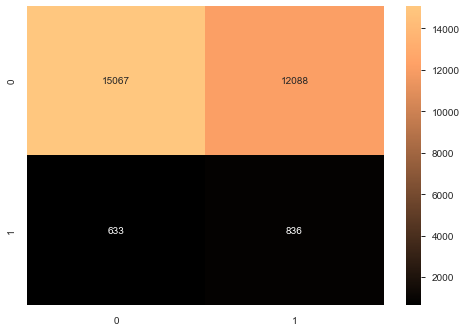


Recall: 0.5745947055202134


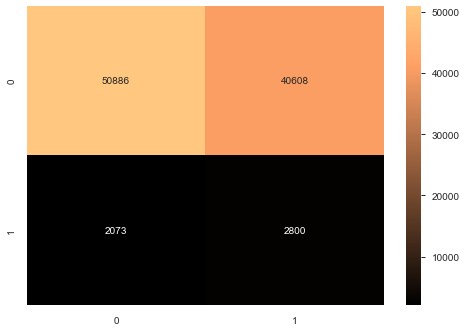

Confusion Matrix: 
 [[50886 40608]
 [ 2073  2800]]
Sensitivity:  0.5745947055202134
Specificity:  0.5561676175486917
AUC Score:  0.5653811615344526
f1 Score:  0.1159876555995112
Accuracy:  0.5570994220013075
None
              precision    recall  f1-score   support

           0       0.96      0.56      0.70     91494
           1       0.06      0.57      0.12      4873

    accuracy                           0.56     96367
   macro avg       0.51      0.57      0.41     96367
weighted avg       0.92      0.56      0.67     96367



In [61]:
# Logistic Regression
Logreg_clf = LogisticRegression(class_weight='balanced', random_state=100) 
# Heading
print('\n','-'*40,'\n',Logreg_clf.__class__.__name__,'\n','-'*40)

# Cross-validate on the train data
print("TRAIN GROUP")
train_cv = cross_val_score(X=X_train, y=y_train, estimator=Logreg_clf, scoring='recall',cv=3) 
print("\nCross-validation recall scores:",train_cv)
print("Mean recall recall:",train_cv.mean())
Logreg_model = Logreg_clf.fit(X_train, y_train)

evaluation(Logreg_model, Logreg_clf, train_cv, '_default')

In [62]:
performance

,Train_Recall,Test_Recall,Test_Specificity
LogisticRegression_default,0.564015,0.569095,0.554852


In [63]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',
                                                np.unique(Y_train_data['TARGET_B']),
                                                Y_train_data['TARGET_B']).tolist()
keys = [0,1]
class_weight_dict = dict(zip(keys, class_weight)) 

In [64]:
class_weight_dict

{0: 0.5267365213262816, 1: 9.85050588478216}

Lets try hyperparameter tuning for LogisticRegression

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:   14.0s finished



 ---------------------------------------- 
 LogisticRegression 
 ----------------------------------------
Best parameters: 

 {'C': 0.009, 'penalty': 'l2'} 

TRAIN GROUP

Cross-validation recall scores: [0.59022222 0.54933333 0.56494662]
Mean recall score: 0.5681673915908791

TEST GROUP

Recall: 0.5670524166099388


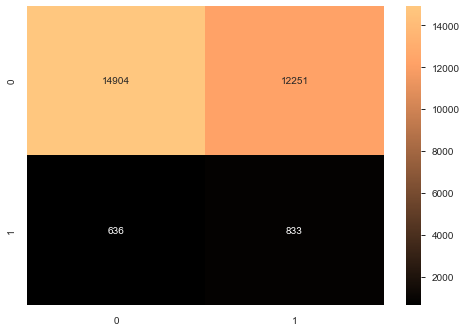


Recall: 0.5670018469115534


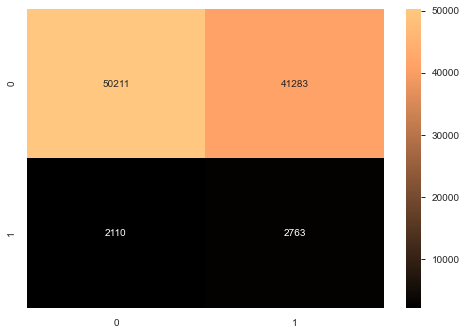

Confusion Matrix: 
 [[50211 41283]
 [ 2110  2763]]
Sensitivity:  0.5670018469115534
Specificity:  0.5487900845957112
AUC Score:  0.5578959657536323
f1 Score:  0.11296224370898832
Accuracy:  0.5497110006537508
None
              precision    recall  f1-score   support

           0       0.96      0.55      0.70     91494
           1       0.06      0.57      0.11      4873

    accuracy                           0.55     96367
   macro avg       0.51      0.56      0.41     96367
weighted avg       0.91      0.55      0.67     96367



In [65]:
# Parameters to optimize
params = [{
    'C': [0.009, 0.01, 0.015, 0.02, 0.03, 0.3],
    'penalty': ['l2', 'l1']
    }]

clf = LogisticRegression(class_weight='balanced', random_state=100)

# Load GridSearchCV
search = GridSearchCV(
    estimator=clf,
    param_grid=params,
    n_jobs=4, cv=5, verbose=1,
    scoring='recall'
)

# Train search object
search.fit(X_train, y_train)

# Heading
print('\n','-'*40,'\n',clf.__class__.__name__,'\n','-'*40)

# Extract best estimator
best = search.best_estimator_
print('Best parameters: \n\n',search.best_params_,'\n')

# Cross-validate on the train data
print("TRAIN GROUP")
train_cv = cross_val_score(X=X_train, y=y_train, 
                           estimator=best, scoring='recall',cv=3)
print("\nCross-validation recall scores:",train_cv)
print("Mean recall score:",train_cv.mean())

Logreg_model_h = best.fit(X_train, y_train)

evaluation(Logreg_model_h, clf, train_cv, '_search')

In [66]:
performance

,Train_Recall,Test_Recall,Test_Specificity
LogisticRegression_default,0.564015,0.569095,0.554852
LogisticRegression_search,0.568167,0.567052,0.548849


#### Random Forest classifier

In [67]:
class_weight_dict = {0: 0.5, 1: 20}


 ---------------------------------------- 
 RandomForestClassifier 
 ----------------------------------------
TRAIN GROUP

Cross-validation recall scores: [0.98933333 0.99022222 0.99288256]
Mean recall score: 0.9908127059443785

TEST GROUP

Recall: 0.9959155888359428


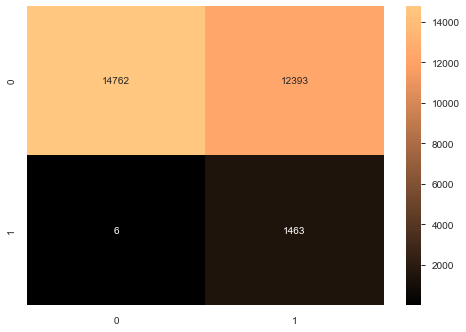


Recall: 0.5208290580751077


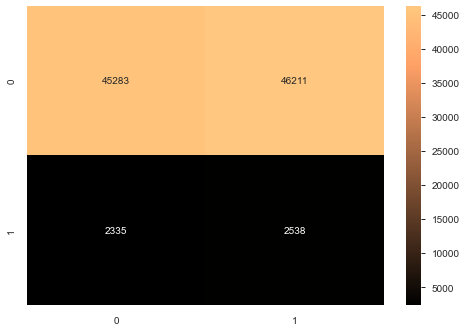

Confusion Matrix: 
 [[45283 46211]
 [ 2335  2538]]
Sensitivity:  0.5208290580751077
Specificity:  0.49492862919972896
AUC Score:  0.5078788436374184
f1 Score:  0.09466263846928501
Accuracy:  0.49623833885043633
None
              precision    recall  f1-score   support

           0       0.95      0.49      0.65     91494
           1       0.05      0.52      0.09      4873

    accuracy                           0.50     96367
   macro avg       0.50      0.51      0.37     96367
weighted avg       0.91      0.50      0.62     96367



In [68]:
# instantiate the classifier with n_estimators = 100

rf_clf = RandomForestClassifier(n_estimators=100, random_state=100, max_depth=6, class_weight=class_weight_dict)

# Heading
print('\n','-'*40,'\n',rf_clf.__class__.__name__,'\n','-'*40)

# Cross-validate on the train data
print("TRAIN GROUP")
train_cv = cross_val_score(X=X_train, y=y_train, estimator=rf_clf, scoring='recall',cv=3)
print("\nCross-validation recall scores:",train_cv)
print("Mean recall score:",train_cv.mean())
rf_model = rf_clf.fit(X_train, y_train)

evaluation(rf_model, rf_clf, train_cv, '_default')

In [69]:
performance

,Train_Recall,Test_Recall,Test_Specificity
LogisticRegression_default,0.564015,0.569095,0.554852
LogisticRegression_search,0.568167,0.567052,0.548849
RandomForestClassifier_default,0.990813,0.995916,0.54362


So far so good, let's now look at the list of hyperparameters which we can tune to improve model performance.

In [70]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [3,4,5],
    'min_samples_leaf': range(5, 30, 5),
    'min_samples_split': range(10, 50, 8),
    'n_estimators': [75, 100,120], 
    'max_features': [6,8,10,12],
    'criterion': ['entropy','gini']
}
# Create a based model
rf = RandomForestClassifier(class_weight=class_weight_dict)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1, scoring= 'f1')
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1800 candidates, totalling 5400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 23.9min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 38.9min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed: 49.4min
[Parallel(n_jobs=-1)]: Done 5400 out of 5400 | elapsed: 55.3min finished


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight={0: 0.5, 1: 20}),
             n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [3, 4, 5], 'max_features': [6, 8, 10, 12],
                         'min_samples_leaf': range(5, 30, 5),
                         'min_samples_split': range(10, 50, 8),
                         'n_estimators': [75, 100, 120]},
             scoring='f1', verbose=1)

In [71]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.187905958262325 using {'criterion': 'gini', 'max_depth': 5, 'max_features': 12, 'min_samples_leaf': 10, 'min_samples_split': 34, 'n_estimators': 75}


**Fitting the final model with the best parameters obtained from grid search.**

In [179]:
# model with the best hyperparameters
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=5,
                             min_samples_leaf=10, 
                             min_samples_split=34,
                             max_features=12,
                             n_estimators=75, random_state=100, class_weight='balanced',criterion='gini')


 ---------------------------------------- 
 RandomForestClassifier 
 ----------------------------------------
TRAIN GROUP

Cross-validation recall scores: [0.91111111 0.91022222 0.90925267]
Mean recall score: 0.9101953341241598

TEST GROUP

Recall: 0.9285228046289993


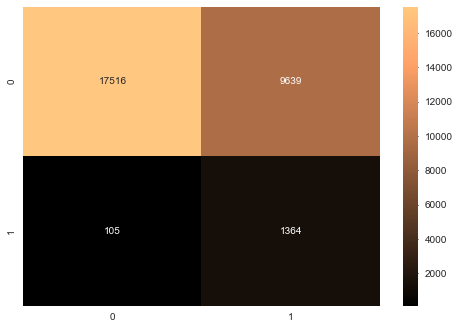


Recall: 0.4436691976195362


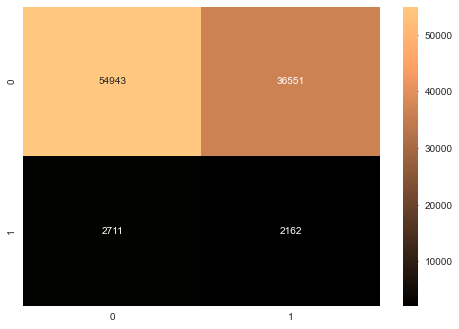

Confusion Matrix: 
 [[54943 36551]
 [ 2711  2162]]
Sensitivity:  0.4436691976195362
Specificity:  0.6005093230157169
AUC Score:  0.5220892603176265
f1 Score:  0.0992061671178819
Accuracy:  0.5925783722643644
None
              precision    recall  f1-score   support

           0       0.95      0.60      0.74     91494
           1       0.06      0.44      0.10      4873

    accuracy                           0.59     96367
   macro avg       0.50      0.52      0.42     96367
weighted avg       0.91      0.59      0.70     96367



In [187]:
# Heading
print('\n','-'*40,'\n',rf_clf.__class__.__name__,'\n','-'*40)

# Cross-validate on the train data
print("TRAIN GROUP")
train_cv = cross_val_score(X=X_train, y=y_train, estimator=rfc, scoring='recall',cv=3)
print("\nCross-validation recall scores:",train_cv)
print("Mean recall score:",train_cv.mean())
rf_model_h = rfc.fit(X_train, y_train)

evaluation(rf_model_h, rfc, train_cv, '_search')

### XGBoost

In [74]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

In [75]:
#Usage
#weight=BalancedSampleWeights(y,1)
xgb_model = XGBClassifier(random_state=123, scale_pos_weight = 125)
xgb_model.fit(X_train, y_train) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=125, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


 ---------------------------------------- 
 XGBClassifier 
 ----------------------------------------
TRAIN GROUP

Cross-validation recall scores: [0.66311111 0.61866667 0.64412811]
Mean recall score: 0.6419686305522604

TEST GROUP

Recall: 0.7542545949625595


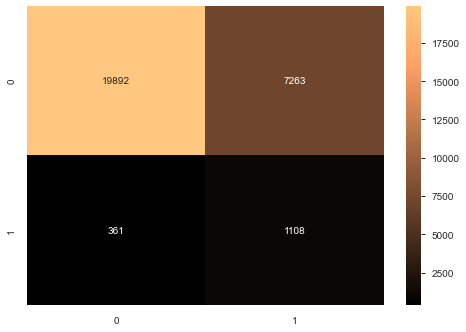


Recall: 0.33839523907243996


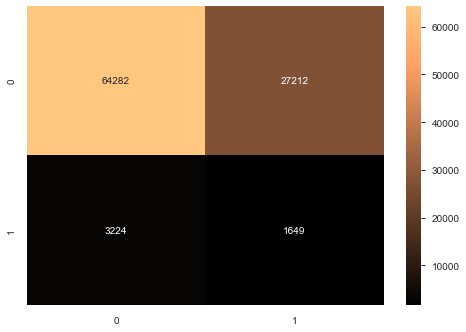

Confusion Matrix: 
 [[64282 27212]
 [ 3224  1649]]
Sensitivity:  0.33839523907243996
Specificity:  0.7025815900496207
AUC Score:  0.5204884145610303
f1 Score:  0.09776486630698998
Accuracy:  0.6841657413844988
None
              precision    recall  f1-score   support

           0       0.95      0.70      0.81     91494
           1       0.06      0.34      0.10      4873

    accuracy                           0.68     96367
   macro avg       0.50      0.52      0.45     96367
weighted avg       0.91      0.68      0.77     96367



In [76]:
# Heading
print('\n','-'*40,'\n',xgb_model.__class__.__name__,'\n','-'*40)

# Cross-validate on the train data
print("TRAIN GROUP")
train_cv = cross_val_score(X=X_train, y=y_train, estimator=xgb_model, scoring='recall',cv=3)
print("\nCross-validation recall scores:",train_cv)
print("Mean recall score:",train_cv.mean())
xgb_model_d = xgb_model.fit(X_train, y_train)

evaluation(xgb_model_d, xgb_model, train_cv, '_default')

### Voting Clasiffier

In [188]:
estimator = list()  
estimator.append(('LR', LogisticRegression(class_weight='balanced')))
estimator.append(('LR_h', LogisticRegression(C=0.3, class_weight='balanced'))) 
estimator.append(('RF', RandomForestClassifier(class_weight={0: 0.5, 1: 20}, max_depth=6,
                        random_state=123))) 
estimator.append(('RF_h', RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=12,
                        min_samples_leaf=10, min_samples_split=34, 
                        random_state=100))) 
estimator.append(('XGB', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.300000012, max_delta_step=0, max_depth=6,
               min_child_weight=1, monotone_constraints='()',
               n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=123,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=125, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None))) 

In [189]:
ensemble = VotingClassifier(estimators=estimator, voting='hard') 
ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('LR',
                              LogisticRegression(class_weight='balanced')),
                             ('LR_h',
                              LogisticRegression(C=0.3,
                                                 class_weight='balanced')),
                             ('RF',
                              RandomForestClassifier(class_weight={0: 0.5,
                                                                   1: 20},
                                                     max_depth=6,
                                                     random_state=123)),
                             ('RF_h',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=5,
                                                     max_features=12,
                                                     min_samples_leaf=10,
                                                     min_samples_sp


 ---------------------------------------- 
 VotingClassifier 
 ----------------------------------------
TRAIN GROUP

Cross-validation recall scores: [0.848      0.80266667 0.82206406]
Mean recall score: 0.8242435745353894

TEST GROUP

Recall: 0.8897208985704561


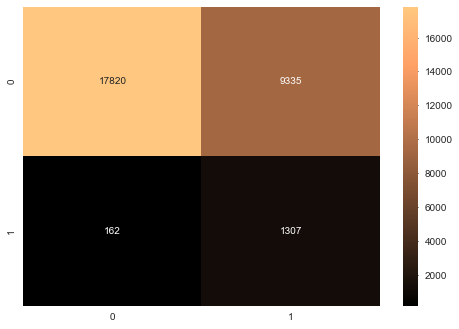


Recall: 0.4395649497229633


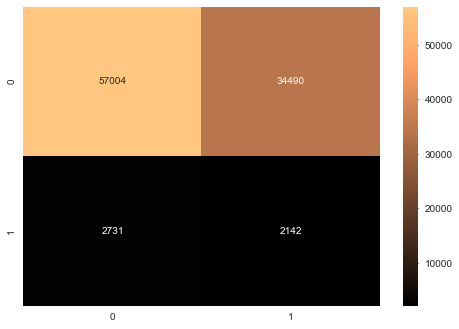

Confusion Matrix: 
 [[57004 34490]
 [ 2731  2142]]
Sensitivity:  0.4395649497229633
Specificity:  0.6230353902988174
AUC Score:  0.5313001700108904
f1 Score:  0.10321647994217564
Accuracy:  0.6137578216609421
None
              precision    recall  f1-score   support

           0       0.95      0.62      0.75     91494
           1       0.06      0.44      0.10      4873

    accuracy                           0.61     96367
   macro avg       0.51      0.53      0.43     96367
weighted avg       0.91      0.61      0.72     96367



In [190]:
# Heading
print('\n','-'*40,'\n',ensemble.__class__.__name__,'\n','-'*40)

# Cross-validate on the train data
print("TRAIN GROUP")
train_cv = cross_val_score(X=X_train, y=y_train, estimator=ensemble, scoring='recall',cv=3)
print("\nCross-validation recall scores:",train_cv)
print("Mean recall score:",train_cv.mean())
ensemble_d = ensemble.fit(X_train, y_train)

evaluation(ensemble_d, ensemble, train_cv, '_default')

In [191]:
#Final predictions 
y_pred_validation = Logreg_model.predict(validation_filtered)

In [81]:
performance

,Train_Recall,Test_Recall,Test_Specificity
LogisticRegression_default,0.564015,0.569095,0.554852
LogisticRegression_search,0.568167,0.567052,0.548849
RandomForestClassifier_default,0.990813,0.995916,0.54362
RandomForestClassifier_search,0.934796,0.93533,0.622721
XGBClassifier_default,0.641969,0.754255,0.732535
VotingClassifier_default,0.815352,0.87951,0.657448


Classification prediction is complete. Lets look at prediction of TARGET_D (Donation amount). 

### Regression modelling

In [82]:
#Required Libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

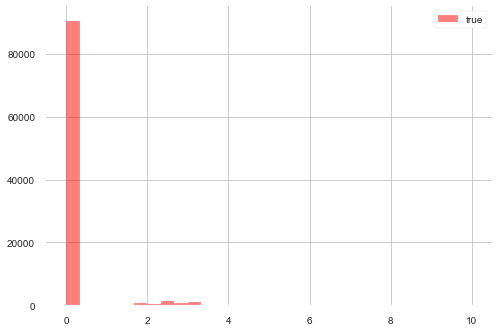

In [83]:
plt.hist(np.log1p(Y_train_data['TARGET_D']), bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.legend();

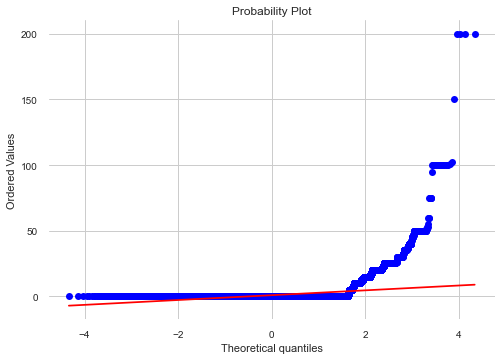

In [84]:
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(Y_train_data['TARGET_D'], plot=plt)
plt.show()

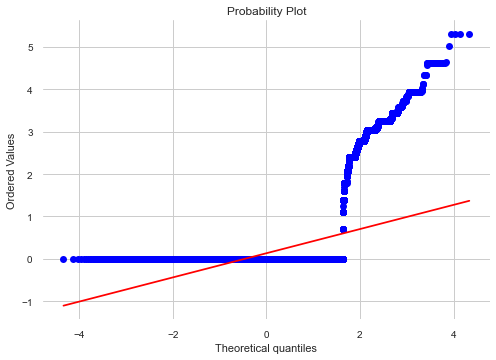

In [85]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
#y = Y_train_data['TARGET_D']
y = np.log1p(Y_train_data['TARGET_D'])

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(np.log1p(Y_train_data['TARGET_D']), plot=plt)
plt.show()

In [86]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(train_filtered, y, test_size = 0.30, random_state = 123)

In [87]:
y_validation_amount = Y_validation_data.TARGET_D.values

In [88]:
y_validation_amount_ln = np.log1p(y_validation_amount)

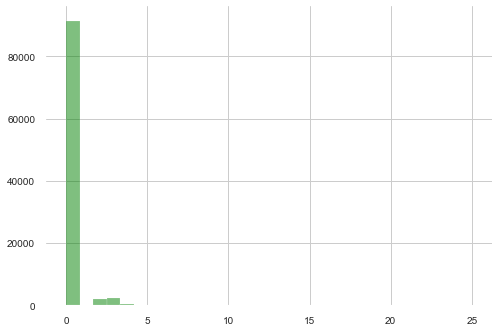

In [89]:
plt.hist(np.log1p(y_validation_amount), bins=30, alpha=.5, color='green', label='Actual Values', range=(0,25))
plt.show()

In [90]:
# DataFrame to store classifier performance
Performance_regression=pd.DataFrame(columns=['Train_NMSE','Test_MAE'])

In [91]:
def evaluation(model, regressor, train_cv, model_type):
    # Now predict on the test group
    print("\nTEST GROUP")
    y_pred = model.predict(X_test)
    
    # Store results
    Performance_regression.loc[regressor.__class__.__name__+model_type,
                    ['Train_NMSE','Test_MAE']] = [
        train_cv.mean(),
        mean_absolute_error(y_test, y_pred)]

### Decision Tree Regressor

In [92]:
seed = 100
kfold_cv = KFold(n_splits=10, random_state=seed)
model_dt = DecisionTreeRegressor(random_state=100)
scoring = 'neg_mean_squared_error'
# Cross-validate on the train data
print("TRAIN GROUP")
train_cv = cross_val_score(model_dt, X=X_train, y=y_train, scoring=scoring,cv=kfold_cv)
print("\nCross-validation error scores:",train_cv)
print("Mean error score:",train_cv.mean())
model_dt_cv = model_dt.fit(X_train, y_train)

evaluation(model_dt_cv, model_dt, train_cv, '_default')

TRAIN GROUP

Cross-validation error scores: [-0.70689028 -0.61352708 -0.69028948 -0.65745958 -0.68630356 -0.66900939
 -0.68129864 -0.67526949 -0.61250832 -0.66038433]
Mean error score: -0.6652940150445283

TEST GROUP


In [93]:
Performance_regression

,Train_NMSE,Test_MAE
DecisionTreeRegressor_default,-0.665294,0.239144


In [94]:
y_validation_dt = model_dt_cv.predict(validation_filtered)
print("\nValidation MAE:",mean_absolute_error(y_validation_amount_ln, y_validation_dt))


Validation MAE: 0.26753677688175437


In [96]:
y_validation_dt_amt = np.expm1(y_validation_dt)

In [97]:
len(y_validation_dt_amt[y_validation_dt_amt > 50])

58

In [98]:
len(y_validation_amount[y_validation_amount > 50])

49

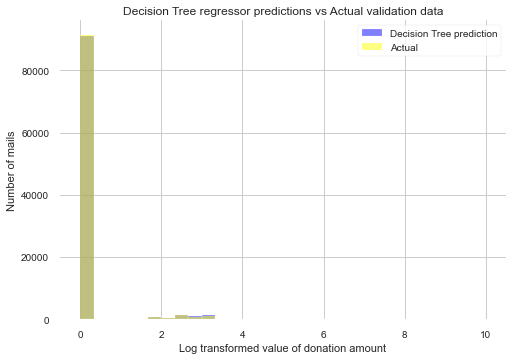

In [99]:
plt.hist(y_validation_dt, bins=30, alpha=.5, color='blue', label='Decision Tree prediction', range=(0,10));
plt.hist(y_validation_amount_ln, bins=30, alpha=.5, color='yellow', label='Actual', range=(0,10));
plt.xlabel('Log transformed value of donation amount')
plt.ylabel('Number of mails')
plt.title('Decision Tree regressor predictions vs Actual validation data')
plt.legend();

### Randomforest Regressor

In [100]:
model_rf = RandomForestRegressor(random_state=100)
model_rf.fit(X_train, y_train)
randomf_pred = model_rf.predict(X_test)
valid_mae = mean_absolute_error(y_test, randomf_pred)
print(valid_mae, np.expm1(valid_mae))

0.237188578106072 0.26768015195842987


In [101]:
randomf_pred = model_rf.predict(X_test)
valid_mae = mean_absolute_error(y_test, randomf_pred)
print(valid_mae, np.expm1(valid_mae))

0.237188578106072 0.26768015195842987


In [102]:
y_validation_randomf = model_rf.predict(validation_filtered)
print("\nValidation MAE:",mean_absolute_error(y_validation_amount_ln, y_validation_randomf))


Validation MAE: 0.2674445528119633


In [103]:
(randomf_pred > 2).sum()

6

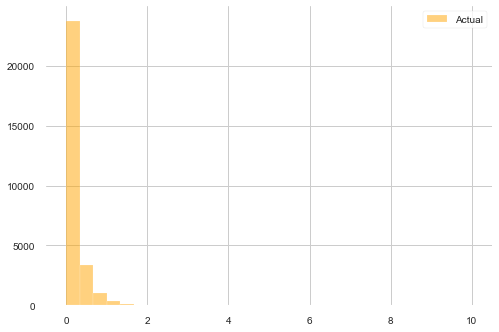

In [104]:
plt.hist(randomf_pred, bins=30, alpha=.5, color='orange', label='Actual', range=(0,10));
plt.legend();

Lets try hyperparameter tuning for Randomforest Regressor

In [107]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(4, 8, num = 3)]
# Minimum number of samples required to split a node
min_samples_split = range(15, 50, 5)
# Minimum number of samples required at each leaf node
min_samples_leaf = range(10, 50, 5)
# Method of selecting samples for training each tree
# bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

pprint(random_grid)
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

{'max_depth': [4, 6, 8],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': range(10, 50, 5),
 'min_samples_split': range(15, 50, 5),
 'n_estimators': [50, 75, 100, 125, 150]}


In [108]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=100, n_jobs = 1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] n_estimators=50, min_samples_split=20, min_samples_leaf=45, max_features=auto, max_depth=4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=50, min_samples_split=20, min_samples_leaf=45, max_features=auto, max_depth=4, total=  13.8s
[CV] n_estimators=50, min_samples_split=20, min_samples_leaf=45, max_features=auto, max_depth=4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.7s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=20, min_samples_leaf=45, max_features=auto, max_depth=4, total=  13.2s
[CV] n_estimators=50, min_samples_split=20, min_samples_leaf=45, max_features=auto, max_depth=4 
[CV]  n_estimators=50, min_samples_split=20, min_samples_leaf=45, max_features=auto, max_depth=4, total=  13.2s
[CV] n_estimators=125, min_samples_split=25, min_samples_leaf=40, max_features=auto, max_depth=4 
[CV]  n_estimators=125, min_samples_split=25, min_samples_leaf=40, max_features=auto, max_depth=4, total=  34.1s
[CV] n_estimators=125, min_samples_split=25, min_samples_leaf=40, max_features=auto, max_depth=4 
[CV]  n_estimators=125, min_samples_split=25, min_samples_leaf=40, max_features=auto, max_depth=4, total=  39.7s
[CV] n_estimators=125, min_samples_split=25, min_samples_leaf=40, max_features=auto, max_depth=4 
[CV]  n_estimators=125, min_samples_split=25, min_samples_leaf=40, max_features=auto, max_depth=4, total=  43.9s
[CV] n_estimators=125, min_samples_split=15, m

[CV]  n_estimators=75, min_samples_split=30, min_samples_leaf=15, max_features=auto, max_depth=8, total=  21.6s
[CV] n_estimators=150, min_samples_split=35, min_samples_leaf=20, max_features=sqrt, max_depth=4 
[CV]  n_estimators=150, min_samples_split=35, min_samples_leaf=20, max_features=sqrt, max_depth=4, total=   4.1s
[CV] n_estimators=150, min_samples_split=35, min_samples_leaf=20, max_features=sqrt, max_depth=4 
[CV]  n_estimators=150, min_samples_split=35, min_samples_leaf=20, max_features=sqrt, max_depth=4, total=   4.1s
[CV] n_estimators=150, min_samples_split=35, min_samples_leaf=20, max_features=sqrt, max_depth=4 
[CV]  n_estimators=150, min_samples_split=35, min_samples_leaf=20, max_features=sqrt, max_depth=4, total=   4.2s
[CV] n_estimators=150, min_samples_split=30, min_samples_leaf=10, max_features=sqrt, max_depth=4 
[CV]  n_estimators=150, min_samples_split=30, min_samples_leaf=10, max_features=sqrt, max_depth=4, total=   4.1s
[CV] n_estimators=150, min_samples_split=30,

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 12.8min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=20, n_jobs=1,
                   param_distributions={'max_depth': [4, 6, 8],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': range(10, 50, 5),
                                        'min_samples_split': range(15, 50, 5),
                                        'n_estimators': [50, 75, 100, 125,
                                                         150]},
                   random_state=100, verbose=2)

In [109]:
#now let's how the RMSE changes for each parameter configuration
cvres2 = rf_random.cv_results_
for mean_score, params in zip(cvres2["mean_test_score"], cvres2["params"]):
    print(np.sqrt(-mean_score), params)

nan {'n_estimators': 50, 'min_samples_split': 20, 'min_samples_leaf': 45, 'max_features': 'auto', 'max_depth': 4}
nan {'n_estimators': 125, 'min_samples_split': 25, 'min_samples_leaf': 40, 'max_features': 'auto', 'max_depth': 4}
nan {'n_estimators': 125, 'min_samples_split': 15, 'min_samples_leaf': 30, 'max_features': 'auto', 'max_depth': 4}
nan {'n_estimators': 150, 'min_samples_split': 35, 'min_samples_leaf': 25, 'max_features': 'sqrt', 'max_depth': 6}
nan {'n_estimators': 50, 'min_samples_split': 30, 'min_samples_leaf': 30, 'max_features': 'sqrt', 'max_depth': 6}
nan {'n_estimators': 75, 'min_samples_split': 25, 'min_samples_leaf': 15, 'max_features': 'auto', 'max_depth': 8}
nan {'n_estimators': 100, 'min_samples_split': 30, 'min_samples_leaf': 35, 'max_features': 'auto', 'max_depth': 8}
nan {'n_estimators': 75, 'min_samples_split': 25, 'min_samples_leaf': 35, 'max_features': 'sqrt', 'max_depth': 6}
nan {'n_estimators': 125, 'min_samples_split': 15, 'min_samples_leaf': 30, 'max_feat

In [110]:
# best random model 
rf_random.best_estimator_

RandomForestRegressor(max_depth=8, min_samples_leaf=15, min_samples_split=30,
                      n_estimators=75)

In [111]:
# best combination of parameters of random search
rf_random.best_params_

{'n_estimators': 75,
 'min_samples_split': 30,
 'min_samples_leaf': 15,
 'max_features': 'auto',
 'max_depth': 8}

In [112]:
# Performance metrics (MAPE)
random_best= rf_random.best_estimator_.predict(X_test)
valid_mae = mean_absolute_error(y_test, random_best)
print(valid_mae, np.expm1(valid_mae))

0.2207539781333009 0.24701659947042684


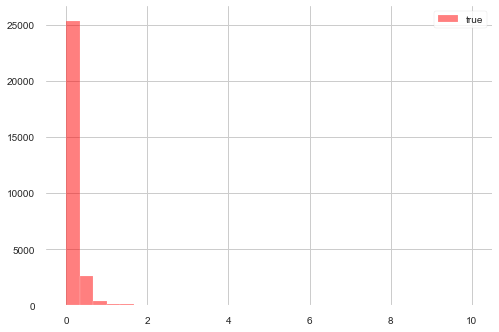

In [113]:
plt.hist(random_best, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.legend();

In [114]:
y_randomf_h = rf_random.best_estimator_.predict(validation_filtered)
print("\nValidation MAE:",mean_absolute_error(y_validation_amount_ln, y_randomf_h))


Validation MAE: 0.24762740679282721


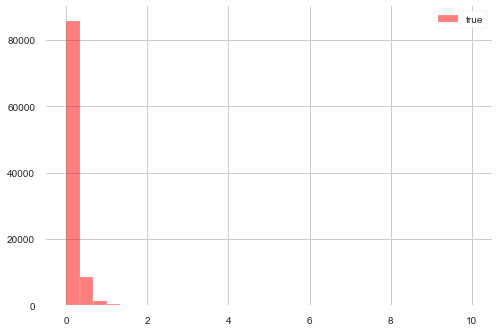

In [115]:
plt.hist(y_randomf_h, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.legend();

In [116]:
# extract the numerical values of feature importance from the grid search
importances = rf_random.best_estimator_.feature_importances_

#create a feature list from the original dataset (list of columns)
# What are this numbers? Let's get back to the columns of the original dataset
feature_list = list(train_filtered.columns)

#create a list of tuples
feature_importance= sorted(zip(importances, feature_list), reverse=True)

#create two lists from the previous list of tuples
df = pd.DataFrame(feature_importance, columns=['importance', 'feature'])
importance= list(df['importance'])
feature= list(df['feature'])

#see df
print(df)

    importance              feature
0     0.609294                  ZIP
1     0.096581              OSOURCE
2     0.014916        FISTDATE_date
3     0.011050        LASTDATE_date
4     0.010848              AVGGIFT
..         ...                  ...
61    0.001069  RAMNT_8_was_missing
62    0.000936             RAMNT_24
63    0.000704             PEPSTRFL
64    0.000637              ODATEDW
65    0.000195               RFA_2A

[66 rows x 2 columns]


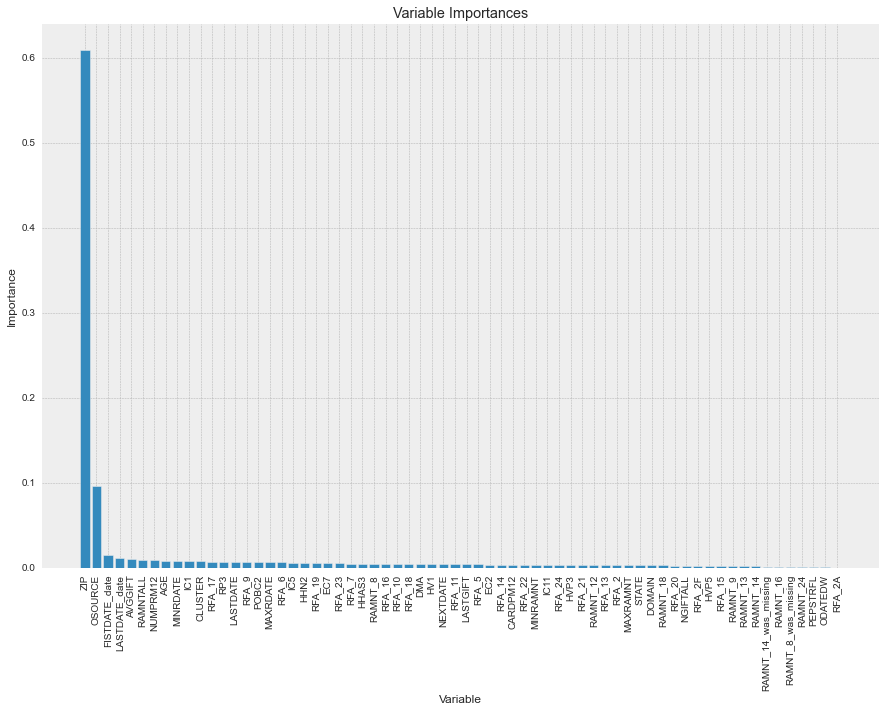

In [117]:
# Set the style
plt.style.use('bmh')
# list of x locations for plotting
x_values = list(range(len(feature_importance)))

# Make a bar chart
plt.figure(figsize=(15,10))
plt.bar(x_values, importance, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

**Train a simple Ridge model and check MAE on the validation set.**

In [118]:
%%time
ridge = Ridge(random_state=17)
ridge.fit(X_train, y_train)

ridge_pred = ridge.predict(X_test)

valid_mae = mean_absolute_error(y_test, ridge_pred)
print(valid_mae, np.expm1(valid_mae))

0.24806340232862834 0.2815411823134623
Wall time: 67.8 ms


In [119]:
y_validation_ridge = ridge.predict(validation_filtered)
print("\nValidation MAE:",mean_absolute_error(y_validation_amount_ln, y_validation_ridge))


Validation MAE: 0.27303767056267575


Lets try hyperparameter tuning for RidgeCV Regressor

In [120]:
%%time
alphas = (0.5, 0.25, 0.1, 1, 1.5, 2, 5)
ridgeCV = RidgeCV(alphas=alphas, cv=5, gcv_mode='auto',
                scoring='neg_mean_absolute_error')

ridgeCV.fit(X_train, y_train);
ridgecv_test_pred = ridgeCV.predict(X_test)
print('alpha: ', ridgeCV.alpha_)
test_mae = mean_absolute_error(y_test, ridgecv_test_pred)
print(test_mae, np.expm1(test_mae))

alpha:  5.0
0.24479978070244354 0.27736553436979744
Wall time: 3 s


In [121]:
y_validation_ridgeCV = ridgeCV.predict(validation_filtered)
print("\nValidation MAE:",mean_absolute_error(y_validation_amount_ln, y_validation_ridgeCV))


Validation MAE: 0.26942624675267146


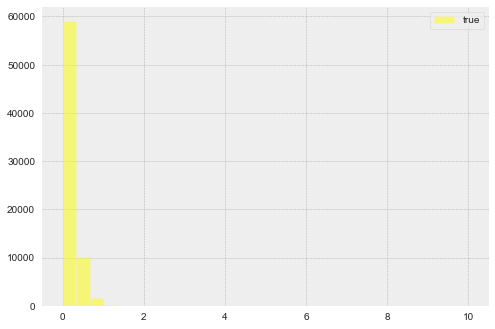

In [122]:
plt.hist(y_validation_ridgeCV, bins=30, alpha=.5, color='yellow', label='true', range=(0,10));
plt.legend();

In [165]:
pred_rfsearch_ridgeCV = .3 * y_randomf_h + .7 * y_validation_dt

In [166]:
print("\nValidation MAE:",mean_absolute_error(y_validation_amount_ln, pred_rfsearch_ridgeCV))


Validation MAE: 0.26059298084446036


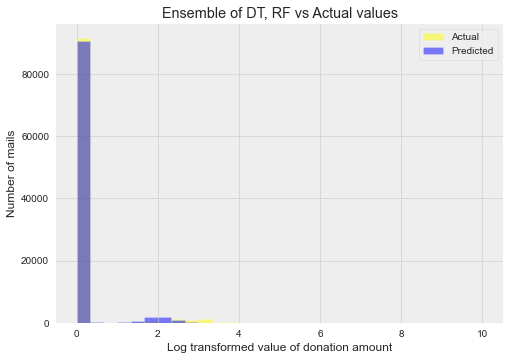

In [167]:
plt.hist(y_validation_amount_ln, bins=30, alpha=.5, color='yellow', label='Actual', range=(0,10));
plt.hist(pred_rfsearch_ridgeCV, bins=30, alpha=.5, color='blue', label='Predicted', range=(0,10));
plt.xlabel('Log transformed value of donation amount')
plt.ylabel('Number of mails')
plt.title('Ensemble of DT, RF vs Actual values')
plt.legend();

In [168]:
pred_donationamt_rf = np.expm1(y_randomf_h)
pred_donationamt_ensemble = np.expm1(pred_rfsearch_ridgeCV)

In [169]:
len(pred_donationamt_ensemble[pred_donationamt_ensemble > 100])

0

In [170]:
len(y_validation_amount[y_validation_amount > 100])

7

### Function to determine the ideal people to target based on the price of the envolope

In [192]:
Y_validation_result = Y_validation_data
Y_validation_result.reset_index(inplace=True)
Y_validation_result['Predicted_TARGET_B'] = pd.Series(y_pred_validation)
Y_validation_result['Predicted_TARGET_D'] = pd.Series(pred_donationamt_ensemble)

In [154]:
def ideal_people_target(envolpe_amount):
    return Y_validation_result[['CONTROLN']][Y_validation_result.Predicted_TARGET_D > envolpe_amount]    

In [173]:
ideal_people_target(0.68)

,CONTROLN
11,156420
34,177347
38,153082
55,5385
67,56325
...,...
96280,184059
96286,92439
96303,33473
96352,67037


In [174]:
ideal_people_target(1)

,CONTROLN
11,156420
34,177347
38,153082
55,5385
67,56325
...,...
96280,184059
96286,92439
96303,33473
96352,67037


In [175]:
Y_validation_result[['Predicted_TARGET_D']][Y_validation_result.Predicted_TARGET_D > 1].sum()  

Predicted_TARGET_D    37813.060829
dtype: float64

In [176]:
ideal_people_target(5)

,CONTROLN
11,156420
34,177347
38,153082
55,5385
67,56325
...,...
96252,29943
96258,119379
96280,184059
96352,67037


In [177]:
Y_validation_result[['Predicted_TARGET_D']][Y_validation_result.Predicted_TARGET_D > 5].sum()  

Predicted_TARGET_D    31576.460958
dtype: float64

In [193]:
Y_validation_result.to_csv('Final_result.csv')

What can be done next... 

**Feature Engineering improvements**

Apply date difference between 06/1997 (Date of mails) and all the date columns

Split the bytes of RFA fields and aggregate the R, F, A bytes of all the RFA_xx columns

Create binary variable whether the person belongs to US West or US East states

Impute the age of the person based on the age of the children 

Better Imputation of null values in categorical columns instead of using SimpleImputer()



**Model development improvements**

Apply SMOTE instead of using class_weight parameters

Try hyper-parameter tuning for gradient boosting algorithms

Work with probabilities from the models to try and adjust the thresholds which results in better predictions (Esp. for Logistic Regression)